In [21]:
# Script to import a Croco history file to be used in OceanParcels

from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4_3D, plotTrajectoriesFile
from netCDF4 import Dataset
from datetime import timedelta, datetime
import numpy as np
from scipy.interpolate import RectBivariateSpline
import os
import pandas as pd

In [40]:
# Import files
his = '../data/config/ROMS/github-test/roms_avg01_2009_datetime.nc'
grd = '../data/config/ROMS/github-test/roms_grd2_1500mVT1.nc'
release_locations_file = "../data/config/test_stations.csv"

In [3]:
# Load in coordinates
fh = Dataset(grd, mode='r+')
lon_psi = fh.variables['lon_psi'][:]
lat_psi = fh.variables['lat_psi'][:]
fh.close

<function Dataset.close>

In [4]:
fh = Dataset(his, mode='r+') #
lon_rho = fh.variables['lon_rho'][:]
lat_rho = fh.variables['lat_rho'][:]
lon_u = fh.variables['lon_u'][:]
lat_u = fh.variables['lat_u'][:]
lon_v = fh.variables['lon_v'][:]
lat_v = fh.variables['lat_v'][:]
Cs_w = fh.variables['Cs_w'][:] # Stretching function of sigma-w C(s_w)
s_w = fh.dimensions['s_w'] # Sigma coords (w)
s_w_v = fh.variables['s_w'] # Sigma coords (w) (variable-ified)
t = fh.variables['time'][:]
h = fh.variables['h'][:] # Depth
zeta = fh.variables['zeta'][:]
h_c = fh.variables['hc'] # Vertical stretching parameter
xi_rho = fh.dimensions['xi_rho'] # (x)
eta_rho = fh.dimensions['eta_rho'] # (y)
zdim = s_w.size # Number of vertical points

In [5]:
# Construct psi grid
depth_psi = np.zeros((zdim, lon_psi.shape[0], lon_psi.shape[1]))

for k in range(zdim):
    # This generates a field showing the depth at each point in the sigma-rho grid
    S_ = (h_c*s_w_v[k] + h*Cs_w[k])/(h_c+h)
    depth_w = zeta[0,:,:]+(zeta[0,:,:]+h)*S_
    
    # Interpolate the sigma-rho depth field to psi locations for OceanParcels
    depth_interp = RectBivariateSpline(lat_rho[:,0], lon_rho[0,:], depth_w)
    depth_psi[k,:,:] = depth_interp(lat_psi[:,0], lon_psi[0, :])

In [6]:
# Write these fields to the nc file if not done already
if 'sigma_psi' in fh.variables:
    pass
else:
    sigma_psi = fh.createVariable('sigma_psi', 'f', dimensions=('s_w', 'eta_v', 'xi_u'))
    sigma_psi[:] = depth_psi # Write sigma_psi to file
    
fh.close

<function Dataset.close>

In [7]:
# Here using the history file for lat-lon-depth since it contains the same
# info as the grid file
    
filenames = {'U': {'lon': grd, 'lat': grd, 'depth': his, 'data': his}, 
             'V': {'lon': grd, 'lat': grd, 'depth': his, 'data': his},
             'W': {'lon': grd, 'lat': grd, 'depth': his, 'data': his},
             'Zeta': {'lon': grd, 'lat': grd, 'data': his}}

variables = {'U': 'u',
             'V': 'v',
             'W': 'w',
             'Zeta': 'zeta'}

dimensions = {'U': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'sigma_psi', 'time': 'time'},
              'V': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'sigma_psi', 'time': 'time'},
              'W': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'sigma_psi', 'time': 'time'},
              'Zeta': {'lon': 'lon_psi', 'lat': 'lat_psi', 'time': 'time'}}

In [8]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [12]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [27]:
release_zone = "test_001"
bathymodiolus_delta_lat = 0.08  #change??

# release particles
number_particles = 100

# release timing
release_time_in_days = 1   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
start_month = 1
start_day = 1

# experiment duration etc
runtime_in_days = 5
dt_in_minutes = 60

In [18]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 200.0)

In [34]:
lon = np.linspace(7,9,num=50)
lat = np.ones([50,])*-23.3
depth= np.ones([50,])*200

In [28]:
time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / dt_in_minutes, size=(number_particles, )
        )
)

######
lat = np.random.normal(
    loc=bathymodiolus_lat, scale=bathymodiolus_delta_lat,
    size=time.shape
)

lon = np.random.normal(
    loc=bathymodiolus_lon, scale=bathymodiolus_delta_lon,
    size=time.shape
)

depth = np.ones(time.size) * release_depth 


In [35]:
pset= ParticleSet(fieldset, JITParticle, lon=lon, lat=lat, depth=depth)

RuntimeError: Field is in deferred_load mode, so can't be accessed. Use .computeTimeChunk() method to force loading of data

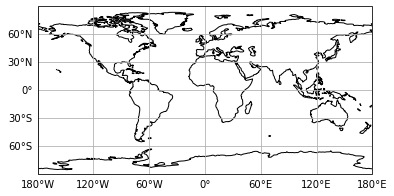

In [36]:
pset.show(field=fieldset.Zeta)

In [37]:
output_file = pset.ParticleFile(name='traj.nc', outputdt=timedelta(hours=1))

In [38]:
pset.execute(AdvectionRK4_3D, runtime=timedelta(days=20), 
             dt=timedelta(seconds=60), output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-1001/libc2481b7cb8ce8504901579caad0f2a18_0.so


IndexError: list assignment index out of range

RuntimeError: Field is in deferred_load mode, so can't be accessed. Use .computeTimeChunk() method to force loading of data

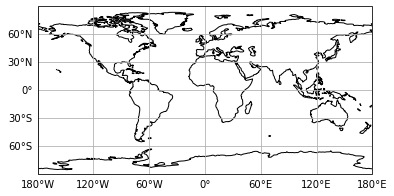

In [33]:
pset.show(field=fieldset.Zeta, time = timedelta(days=20))